# 1. Загрузка данных

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

In [ ]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [ ]:
def show_plots(series, r=3, c=2):
  fig, ax = plt.subplots(r, c, figsize=(14, 8))

  for i, key in enumerate(series):
    ax_i = ax[math.floor(i/c)][i%c]
    series[key].plot(ax=ax_i)

    ax_i.grid()
    ax_i.set_title(key)
    plt.tight_layout()

In [ ]:
show_plots(all_series)

# 2. Приведение ряда к стационарному

In [ ]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [ ]:
fix_series = {}

for key in all_series.keys():
  series = boxcox(all_series[key], 0)
  series = series[12:] - series[:-12]
  series = series[1:] - series[:-1]
  fix_series[key] = pd.Series(series)

show_plots(fix_series)

# 2. ARIMA

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
def tsplot(y, key, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{key}\nOriginal')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [ ]:
def get_arima(series, N=5):
  best_aic = np.inf
  best_order = None
  best_mdl = None

  for p in range(N):
    for d in range(N):
      for q in range(N):
        tmp_mdl = ARIMA(series, order=(p,d,q)).fit()
        tmp_aic = tmp_mdl.aic
        if tmp_aic < best_aic:
          best_aic = tmp_aic
          best_order = (p, d, q)
          best_mdl = tmp_mdl

  print(f'aic: {best_aic} | order: {best_order}')
  print(f"p-value: {adfuller(best_mdl.resid, autolag='AIC')[1]}")

  tsplot(best_mdl.resid, key, lags=30)

  return best_mdl, best_aic, best_order

aic: -7.5805017540281945 | order: (3, 0, 4)
p-value: 1.7607316744268363e-07


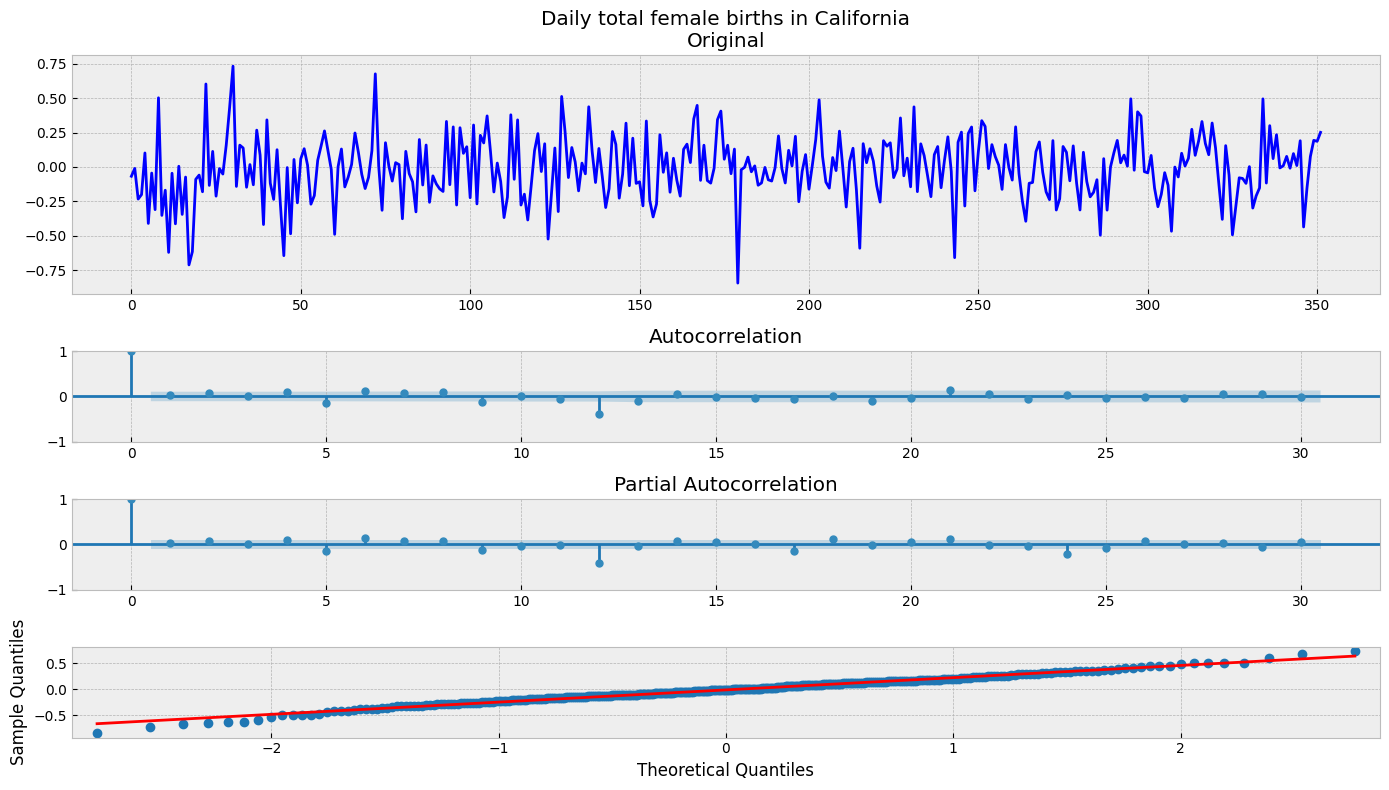

In [74]:
series = fix_series['Daily total female births in California']
best_mdl, best_aic, best_order = get_arima(series)

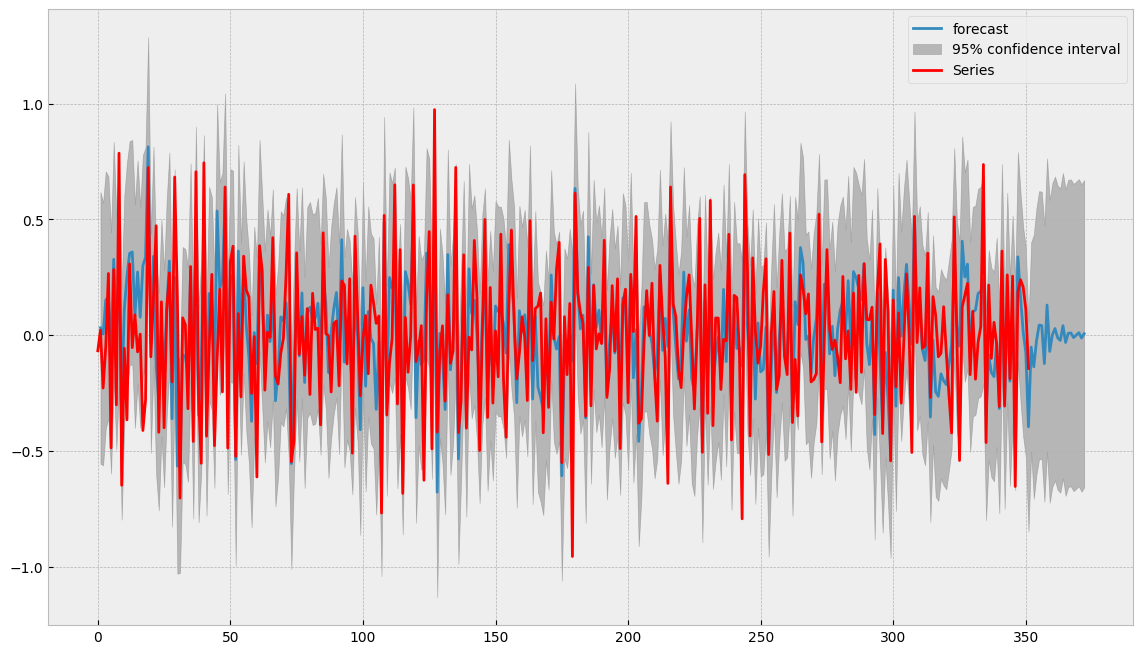

In [78]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [76]:
len_train = int(len(series)*0.8)

tmp_mdl = ARIMA(series[:len_train], order=best_order).fit()
pred = tmp_mdl.forecast(len(series) - len_train)
print(f'R2 = {r2_score(pred, series[len_train:])}')
print(f'RMSE = {np.sqrt(mean_squared_error(pred, series[len_train:]))}')

R2 = -42.92913195078844
RMSE = 0.2741029822370719
